# 📚 Libraries


In [1]:
import torch
import spacy
import transformers
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Any
from os import PathLike
from typing import Callable
from torch import nn, optim
from zenml.environment import Environment
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from transformers.modeling_utils import PreTrainedModel
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoConfig,
    get_linear_schedule_with_warmup,
)
from huggingface_hub import notebook_login, PyTorchModelHubMixin

# 🥼 Google Colab


In [2]:
if Environment.in_google_colab():
    print(f"🥼 Running on Google Colab")

    from google.colab import drive

    drive.mount("/content/drive")

    data_path = (
        "/content/drive/My Drive/Colab Notebooks/Natural Language Processing/Project"
    )
else:
    data_path = "./"

# 🧑‍💻 CUDA Specification


In [3]:
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

# 🧘‍♂️ ZenML


In [4]:
# Environment

# 📚 Import Data


In [5]:
df_train = pd.read_csv(f"{data_path}/data/train_clean.csv.zip")
df_val = pd.read_csv(f"{data_path}/data/val_clean.csv.zip")
df_test = pd.read_csv(f"{data_path}/data/test_clean.csv.zip")

In [6]:
print(f"🏃‍♂️ Train shape: {df_train.shape}")
print(f"🏋️ Validation shape: {df_val.shape}")
print(f"🧐 Test shape: {df_test.shape}")

🏃‍♂️ Train shape: (5000, 15)
🏋️ Validation shape: (1310, 15)
🧐 Test shape: (1455, 15)


## 📖 Define the data


In [7]:
MODEL_NAME = "bert-base-uncased"
MODEL_TYPE = "bert"
SPACY_MODEL = "en_core_web_sm"

In [8]:
GENRE_MAPPING = {"edm": 0, "r&b": 1, "rap": 2, "rock": 3, "pop": 4}

In [9]:
AUDIO_FEATURES = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence",
]

In [10]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 2e-05

# 🧩 Tokenizer


In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 🧠 Preprocessing


In [12]:
class LyricsAudioDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.scaler = StandardScaler()
        self.data = dataframe
        self.lyrics = dataframe.lyrics
        self.audio = self.scaler.fit_transform(dataframe[AUDIO_FEATURES])
        self.targets = self.data.playlist_genre_id
        self.max_len = max_len

        # Load Spacy model for text preprocessing
        self.nlp = spacy.load(SPACY_MODEL, disable=["parser", "ner"])

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, index):
        lyrics = self._preprocess_lyrics(str(self.lyrics[index]))

        inputs = self.tokenizer.encode_plus(
            lyrics,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True,
        )

        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "audio": torch.tensor(self.audio[index], dtype=torch.float),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

    def _preprocess_lyrics(self, text):
        doc = self.nlp(text)
        processed_text = " ".join(
            [
                token.lemma_.lower().strip()
                for token in doc
                if not token.is_stop and token.lemma_.isalpha()
            ]
        )
        return processed_text

In [13]:
training_set = LyricsAudioDataset(df_train, tokenizer, MAX_LEN)
validation_set = LyricsAudioDataset(df_val, tokenizer, MAX_LEN)
testing_set = LyricsAudioDataset(df_test, tokenizer, MAX_LEN)

In [14]:
train_params = {"batch_size": TRAIN_BATCH_SIZE, "shuffle": True, "num_workers": 0}
val_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": False, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

# 📐 Modeling


In [15]:
class LyricAudioModel(PreTrainedModel, PyTorchModelHubMixin):
    def __init__(self, dropout_rate=0.3):
        self.pretrained_config = AutoConfig.from_pretrained(MODEL_NAME)
        super(LyricAudioModel, self).__init__(config=self.pretrained_config)

        self.l1 = AutoModel.from_pretrained(MODEL_NAME, config=self.pretrained_config)
        self.audio_mlp = nn.Sequential(
            nn.Linear(len(AUDIO_FEATURES), self.pretrained_config.hidden_size),
            nn.BatchNorm1d(self.pretrained_config.hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        self.pre_classifier = nn.Linear(
            self.pretrained_config.hidden_size * 2, self.pretrained_config.hidden_size
        )
        self.batch_norm = nn.BatchNorm1d(self.pretrained_config.hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(
            self.pretrained_config.hidden_size, len(GENRE_MAPPING)
        )

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None, audio=None
    ) -> torch.Tensor:
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        audio_out = self.audio_mlp(audio)
        pooler = torch.cat((pooler, audio_out), 1)  # Early fusion
        pooler = self.pre_classifier(pooler)
        pooler = self.batch_norm(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)

        output = self.classifier(pooler)

        return output

    def save_pretrained(
        self,
        save_directory: str | PathLike,
        is_main_process: bool = True,
        state_dict: dict | None = None,
        save_function: Callable[..., Any] = torch.save,
        push_to_hub: bool = False,
        max_shard_size: int | str = "5GB",
        safe_serialization: bool = True,
        variant: str | None = None,
        token: str | bool | None = None,
        save_peft_format: bool = True,
        **kwargs,
    ):
        return super().save_pretrained(
            save_directory,
            is_main_process,
            state_dict,
            save_function,
            push_to_hub,
            max_shard_size,
            safe_serialization,
            variant,
            token,
            save_peft_format,
            **kwargs,
        )

    def from_pretrained(
        cls,
        pretrained_model_name_or_path: str,
        *model_args,
        **kwargs,
    ):
        return super().from_pretrained(
            pretrained_model_name_or_path,
            *model_args,
            **kwargs,
        )

In [16]:
model = LyricAudioModel()
model.to(device)

LyricAudioModel(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [17]:
loss_function = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(device)
)


optimizer = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=0.005)

num_warmup_steps = len(training_loader) * EPOCHS * 0.1
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(training_loader) * EPOCHS,
)

In [18]:
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx == targets).sum().item()
    return n_correct

## 🧪 Training


In [19]:
def train(epoch, model, train_loader, loss_function, optimizer, device):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    model.train()

    print(f"🏃‍♂️ Training Epoch: {epoch + 1}")

    for _, batch in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
        audio_features = batch["audio"].to(device, dtype=torch.float)
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
        loss = loss_function(outputs, targets)
        total_loss += loss.item()

        # Calculate and accumulate correct predictions
        _, predictions = torch.max(outputs.data, dim=1)
        correct_predictions += (predictions == targets).sum().item()

        total_samples += targets.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update the learning rate
        scheduler.step(correct_predictions)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Training Epoch {epoch + 1} Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 📈 Evaluation


In [20]:
def evaluate(model, eval_loader, loss_function, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    print(f"🧐 Evaluating Model...")

    with torch.no_grad():
        for _, batch in tqdm(enumerate(eval_loader, 0), total=len(eval_loader)):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            # Calculate and accumulate correct predictions
            _, predictions = torch.max(outputs.data, dim=1)
            correct_predictions += (predictions == targets).sum().item()

            total_samples += targets.size(0)

    epoch_loss = total_loss / len(eval_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Evaluation Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 🥧 Complie


In [21]:
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

best_validation_loss = float("inf")

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train(
        epoch, model, training_loader, loss_function, optimizer, device
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    validation_loss, validation_accuracy = evaluate(
        model, validation_loader, loss_function, device
    )
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        model.save_pretrained(f"{data_path}/model")
        print(f"🎉 Model saved at epoch {epoch + 1}")
    else:
        print("🚨 Early stopping! Validation loss hasn't improved. Stopping training.")
        break

print("🎯 Training complete!")

🏃‍♂️ Training Epoch: 1


100%|██████████| 625/625 [04:57<00:00,  2.10it/s]


🏁 Training Epoch 1 Complete | Loss: 1.2885 | Accuracy: 46.32%

🧐 Evaluating Model...


100%|██████████| 328/328 [00:48<00:00,  6.73it/s]


🏁 Evaluation Complete | Loss: 1.0853 | Accuracy: 56.79%

🎉 Model saved at epoch 1
🏃‍♂️ Training Epoch: 2


100%|██████████| 625/625 [05:00<00:00,  2.08it/s]


🏁 Training Epoch 2 Complete | Loss: 1.0271 | Accuracy: 60.52%

🧐 Evaluating Model...


100%|██████████| 328/328 [00:50<00:00,  6.50it/s]


🏁 Evaluation Complete | Loss: 0.9712 | Accuracy: 61.83%

🎉 Model saved at epoch 2
🏃‍♂️ Training Epoch: 3


100%|██████████| 625/625 [04:55<00:00,  2.12it/s]


🏁 Training Epoch 3 Complete | Loss: 0.8757 | Accuracy: 67.46%

🧐 Evaluating Model...


100%|██████████| 328/328 [00:49<00:00,  6.59it/s]


🏁 Evaluation Complete | Loss: 0.9553 | Accuracy: 62.21%

🎉 Model saved at epoch 3
🏃‍♂️ Training Epoch: 4


100%|██████████| 625/625 [04:58<00:00,  2.09it/s]


🏁 Training Epoch 4 Complete | Loss: 0.7008 | Accuracy: 74.88%

🧐 Evaluating Model...


100%|██████████| 328/328 [00:48<00:00,  6.78it/s]

🏁 Evaluation Complete | Loss: 1.1189 | Accuracy: 57.48%

🚨 Early stopping! Validation loss hasn't improved. Stopping training.
🎯 Training complete!


# 🏆 The Best Model


# 😵 Report


In [25]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for _, batch in tqdm(
            enumerate(data_loader, 0), total=len(data_loader), desc="Predicting"
        ):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            _, preds = torch.max(outputs, dim=1)

            predictions.append(preds)
            real_values.append(targets)

    predictions = torch.cat(predictions).cpu()
    real_values = torch.cat(real_values).cpu()

    return predictions, real_values

In [26]:
y_pred, y_test = get_predictions(model, testing_loader)
report = classification_report(
    y_test, y_pred, target_names=GENRE_MAPPING.keys(), output_dict=True
)

print("📊 Classification Report")
print(classification_report(y_test, y_pred, target_names=GENRE_MAPPING.keys()))

Predicting: 100%|██████████| 364/364 [00:32<00:00, 11.19it/s]


📊 Classification Report
              precision    recall  f1-score   support

         edm       0.72      0.60      0.65       319
         r&b       0.80      0.70      0.75       259
         rap       0.65      0.56      0.60       321
        rock       0.51      0.44      0.47       390
         pop       0.36      0.77      0.49       166

    accuracy                           0.58      1455
   macro avg       0.61      0.61      0.59      1455
weighted avg       0.62      0.58      0.59      1455



In [27]:
print(f"📊 Save Classification Report")
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{data_path}/report/classification_report.csv", index=False)

📊 Save Classification Report


# 📊 Visualization


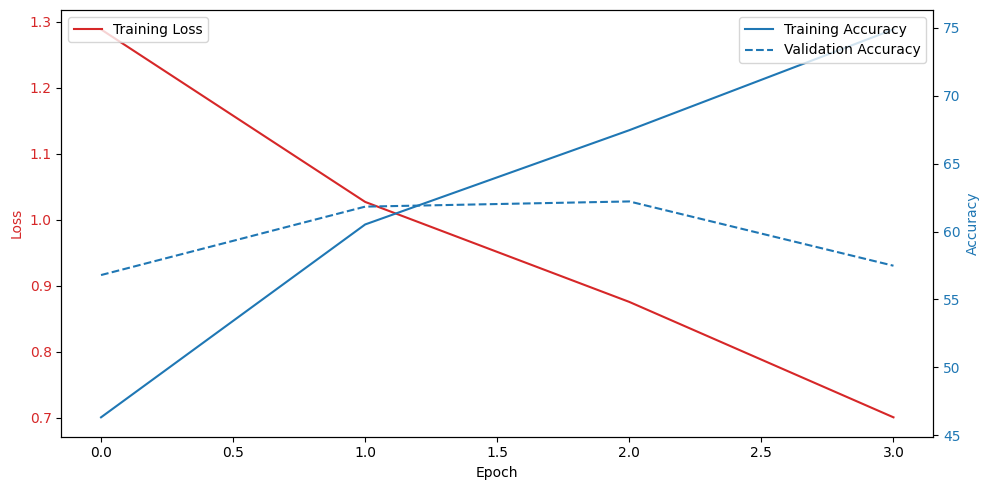

In [28]:
def plot_metrics(train_losses, train_accuracies, validation_accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(train_losses, label="Training Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")

    ax2.plot(train_accuracies, label="Training Accuracy", color="tab:blue")
    ax2.plot(
        validation_accuracies,
        label="Validation Accuracy",
        linestyle="--",
        color="tab:blue",
    )
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()
    fig.savefig(f"{data_path}/report/metrics.png")


plot_metrics(train_losses, train_accuracies, validation_accuracies)

# ☁️ Upload to Hugging Face


In [29]:
if validation_accuracies[-1] > 50.0:
    repository_name = "PunGrumpy/music-genre-classification"

    config = AutoConfig.from_pretrained(f"{data_path}/model/config.json")

    model.push_to_hub(repository_name, token=True, config=config if config else None)
    tokenizer.push_to_hub(repository_name, token=True)
    print(f"Model pushed to {repository_name}")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

c:\Users\grumpy\anaconda3\envs\nlp\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\grumpy\.cache\huggingface\hub\models--PunGrumpy--music-genre-classification. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Model pushed to PunGrumpy/music-genre-classification
